<a href="https://colab.research.google.com/github/armitakar/GGS366_Spatial_Computing/blob/main/Lectures/9_Network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Network analysis helps us understand how people, information, and
goods move across spatial networks.

**Network** is a set of connected features, mathematically known as **Graph**. A **network graph** is made up of:
- **Nodes (junctions/point locations)**: locations in which edges meet in a network
- **Edges (lines/links)**: pathways that connect nodes


![image](https://mathinsight.org/media/image/image/small_undirected_network_labeled.png)


Network analysis evalautes the cost, time, and resources required to traverse across a network. Goal is **to minimize the cost to ensure efficient movement and resource allocations**.

In this lecture, we will first learn about OpenStreetMap, from which we will extract road network data. Then we will discuss two commonly-used network analysis approaches: **Shortest path** and **service area analysis**. We will combinedly used [OSMnx](https://osmnx.readthedocs.io/en/stable/) and [NetworkX](https://networkx.org/) for these analysis.



# Library

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.0 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Data from OpenStreetMap

[OpenStreetMap (OSM)](https://www.openstreetmap.org/about) is a crowdsourced global map database that provides detailed information about various built and natural environment features, including roads, buildings, vegetation, and water bodies. To better understand OSM's data structure, check out their wiki page: https://wiki.openstreetmap.org/wiki/Map_features

OSMnx is a Python package designed for retrieving, analyzing, and visualizing OpenStreetMap data. Developed by Dr. Geoff Boeing, this library is particularly useful for extracting and analyzing road network data. Additionally, you can extract other spatial features too, such as administrative boundaries, buildings, Point-of-Interest (POI), greenspaces, waterbodies etc.  

Learn more about OSMnx from this research article:
- Boeing, G. (2017). OSMnx: New methods for acquiring, constructing, analyzing, and visualizing complex street networks. Computers, environment and urban systems, 65, 126-139. https://www.researchgate.net/publication/309738462_OSMNX_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks

For clarification on any OSMnx function, read their user guide:
- https://osmnx.readthedocs.io/en/stable/user-reference.html

Some other useful references:
- https://github.com/gboeing/osmnx-examples/tree/main
- https://geoffboeing.com/2016/11/osmnx-python-street-networks/
- https://gdsl-ul.github.io/wma/labs/w07_OSM.html#what-is-openstreetmap
- https://pygis.io/docs/d_access_osm.html




With OSMnx, we can extract **administrative place boundaries** for any location. By passing the place name to the **geocode_to_gdf** function, we can retrieve the corresponding OSM polygon boundary as a GeoDataFrame.

In [ ]:
# Specify the place name that is used to search for the data
place_name = "Alexandria, Virginia, United States"
# get the boundary data as geodataframe
area = ox.geocode_to_gdf(place_name)
area

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-77.14436 38.81036, -77.14377 38.807...",-77.144358,38.785184,-77.037039,38.844923,321157293,relation,206637,38.80511,-77.047023,boundary,administrative,12,0.605838,city,Alexandria,"Alexandria, Virginia, United States"


<Axes: >

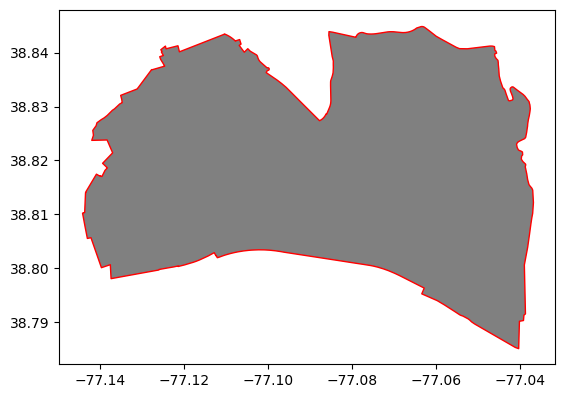

In [ ]:
area.plot(facecolor = "grey", edgecolor = "red")

To retrieve spatial features from OSM data, you can use the **feature_from_place** function. Each feature in the OSM map is stored using **key-value pair tags**. Here, the keys represent broad feature categories, such as highway, landuse, boundary, or building, while the values specify subcategories within those broader categories.

For example, a feature tagged as highway (key) can be further classified as a residential road (value). Likewise, a feature tagged as building (key) can be classified as apartments (value).

The type of feature you extract using the feature_from_place function depends on the key-value tags you specify. To find the correct key-value pairs, use [OSM wiki page](https://wiki.openstreetmap.org/wiki/Map_features).

In [ ]:
# retrieve buildings for the area
tags = {"building": True}
buildings = ox.features_from_place(place_name, tags).reset_index()

In [ ]:
# specifying building as True will return all buildings regardless of their sub-category
buildings.building.unique()

array(['yes', 'public', 'residential', 'school', 'house', 'apartments',
       'church', 'terrace', 'parking', 'commercial', 'college',
       'detached', 'train_station', 'government', 'office', 'retail',
       'service', 'roof', 'industrial', 'hotel', 'memorial', 'garage',
       'toilets', 'semidetached_house', 'shed', 'university', 'warehouse',
       'hospital', 'poolhouse', 'religious', 'social_facility', 'civic',
       'yes;public', 'garages', 'fire_station', 'health', 'construction'],
      dtype=object)

<Axes: >

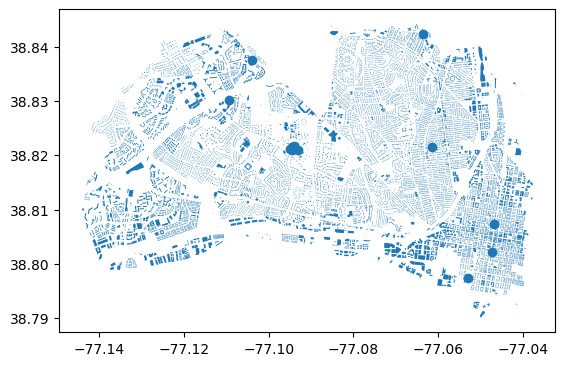

In [ ]:
# Note that the output contains mixed geometries (point, polygon etc.)
buildings.plot()

In [ ]:
# We can further extract building footprints by filtering only the polygon geometry types
buildings = buildings.loc[buildings.geometry.type=='Polygon']
# the output is just a geodataframe, we can export it as usual if needed
# buildings.to_file('fairfax_buildings.shp')

In the same way, we can extract land use information. Instead of using {'landuse': True}, we can specify a list of values to extract specific land use types.

<Axes: >

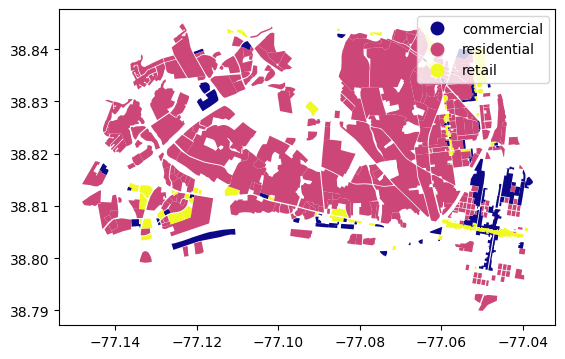

In [ ]:
# retrieve landuse for the area
tags = {'landuse': ['commercial', 'residential', 'retail']}
landuse = ox.features_from_place(place_name, tags).reset_index()
landuse.plot(column = "landuse", legend = True, cmap = "plasma")

# Road network data

OSMnx provides several functions to retrieve road network data as graphs, which include node and edge information. These functions can extract networks based on a place name, a minimum bounding rectangle, or specific coordinate values. The output is a **NetworkX graph object**. By default, the graphs generated by OSMnx are **MultiDiGraph** ([Multi-Directed Graphs](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)), meaning that there can be multiple edges between two nodes (e.g., parallel streets) and each edge has a direction associated with it (one-way or bidirectional).

In this lecture, we will use the **graph_from_place** function, where you provide a place name as input to get the network data.

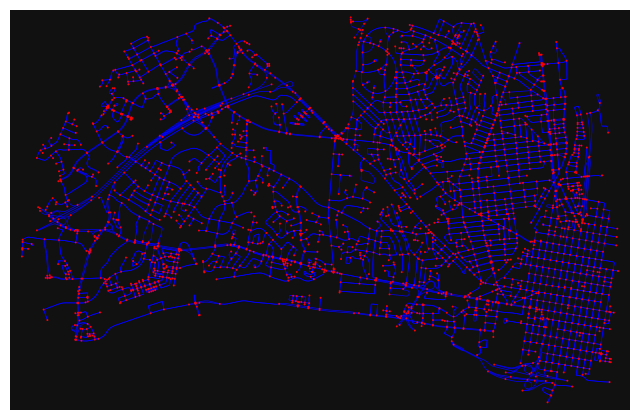

In [ ]:
# Fetch OSM street network from the location
G = ox.graph_from_place(place_name,
                        network_type='drive') # network type options are all, drive, walk, bike
# use osmnx plot_graph function to visualize
# red dots are the nodes, blue lines are the edges
fig, ax = ox.plot_graph(G, node_color= 'red', node_size= 2, edge_color='blue', edge_linewidth= 0.5)

In [ ]:
# the output is a networkx MultiDiGraph
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [ ]:
# you can convert MultiDiGraph to GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes = gdf_nodes.reset_index()
gdf_edges = gdf_edges.reset_index()

<Axes: >

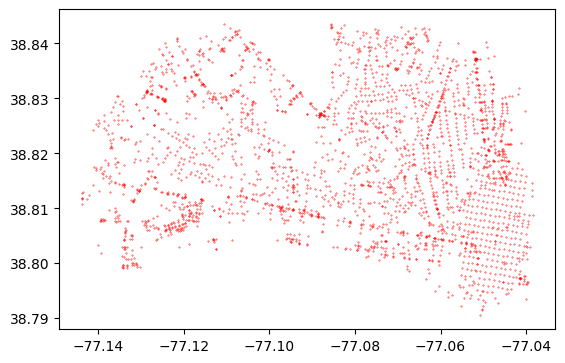

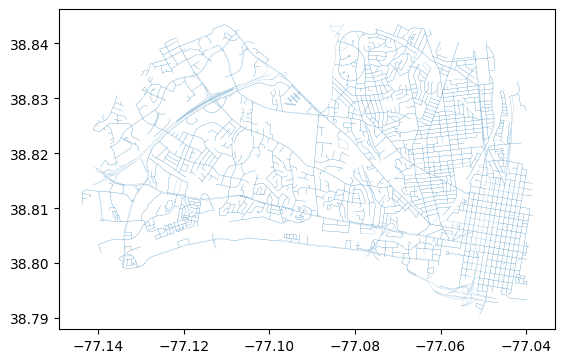

In [ ]:
# plotting nodes geodataframe
gdf_nodes.plot(markersize = 0.1, color = "red")
# plotting edges geodataframe
gdf_edges.plot(lw = 0.1)

In [ ]:
# The OSMid serve as the unique identifier for each node
gdf_nodes.head()

,osmid,y,x,highway,street_count,ref,geometry
0,287905,38.843458,-77.110659,traffic_signals,4,NaN,POINT (-77.11066 38.84346)
1,63338863,38.840269,-77.104421,NaN,3,NaN,POINT (-77.10442 38.84027)
2,63338885,38.839886,-77.103569,NaN,3,NaN,POINT (-77.10357 38.83989)
3,63344995,38.840063,-77.103955,NaN,3,NaN,POINT (-77.10396 38.84006)
4,63344997,38.840102,-77.104042,NaN,3,NaN,POINT (-77.10404 38.8401)


The (u, v, key) combination serves as the unique identifier for each edge
- u: start node
- v: end node
- key: A unique identifier for edges between the same pair of nodes. Since a MultiDiGraph allows multiple edges between the same nodes (e.g., parallel streets or different travel directions), the key differentiates them.

In [ ]:
# (u,v, key) as unique edge identifier
gdf_edges.head()

,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,reversed,length,geometry,ref,access,width,bridge,junction,tunnel
0,287905,63755704,0,"[999712204, 8824926]",tertiary,2,25 mph,Dawes Avenue,False,False,455.818631,"LINESTRING (-77.11066 38.84346, -77.11076 38.8...",NaN,NaN,NaN,NaN,NaN,NaN
1,287905,623691150,0,"[468774721, 468774722, 468774723]",primary,"[4, 5]",35 mph,King Street,False,True,148.790969,"LINESTRING (-77.11066 38.84346, -77.1103 38.84...",VA 7,NaN,NaN,NaN,NaN,NaN
2,63338863,63344997,0,8796248,tertiary,NaN,25 mph,South Columbus Street,False,True,37.713612,"LINESTRING (-77.10442 38.84027, -77.10438 38.8...",NaN,NaN,NaN,NaN,NaN,NaN
3,63338863,623691866,0,488817575,tertiary,2,25 mph,South 28th Street,False,True,136.426282,"LINESTRING (-77.10442 38.84027, -77.10453 38.8...",NaN,NaN,NaN,NaN,NaN,NaN
4,63338885,63344995,0,8796248,tertiary,NaN,25 mph,South Columbus Street,False,False,38.798969,"LINESTRING (-77.10357 38.83989, -77.10372 38.8...",NaN,NaN,NaN,NaN,NaN,NaN


Currently, the network data is in the geographic coordinate system (EPSG:4326), which can be problematic for calculating distances and travel times. To address this, we can reproject the graph to EPSG:3857 using the **project_graph** function.

In [ ]:
G = ox.project_graph(G, to_crs='EPSG:3857')

Although the node and edge geometries are reprojected, the length column is not automatically updated to reflect the new coordinate reference system (CRS). We need to recalculate the length column accordingly.

In [ ]:
# get the nodes and edges gdf first
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes = gdf_nodes.reset_index()
gdf_edges = gdf_edges.reset_index()

# you can check that the old length column is not the same as geometric length with new CRS
# here're some random examples
print(gdf_edges['length'][0], gdf_edges.geometry[0].length)
print(gdf_edges['length'][8], gdf_edges.geometry[8].length)
print(gdf_edges['length'][100], gdf_edges.geometry[100].length)

455.81863110827504 585.8827728655283
136.42628227291527 175.34896412983127
23.08457775106275 29.663494035990244


In [ ]:
# we can update the length column based on geometric length on the geodataframe
gdf_edges['length'] = gdf_edges.geometry.length

# Then we need to convert the geodataframes back to multidigraph for further analysis
graph_attrs = {"crs": "EPSG:3857"}                   # graph CRS
gdf_nodes = gdf_nodes.set_index(['osmid'])           # node identifier
gdf_edges = gdf_edges.set_index(['u','v','key'])     # edge identifier

# convert geodataframe to multidigraph
G_new = ox.graph_from_gdfs(gdf_nodes = gdf_nodes, gdf_edges = gdf_edges, graph_attrs = graph_attrs)

Lastly, we can retrieve road speed limits and calculate edge travel times (in seconds) using the edge lengths and speed limits.

In [ ]:
G_new = ox.add_edge_travel_times(ox.add_edge_speeds(G_new))

In [ ]:
# here I manually calculated travel time for index 0 to double check if the returned travel time estimations are right.
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_new)
gdf_nodes = gdf_nodes.reset_index()
gdf_edges = gdf_edges.reset_index()

# manual calculation
print(3600 * (gdf_edges['length'][0]/1000)/gdf_edges['speed_kph'][0])
# output from the add_edge_travel_times function
print(gdf_edges['travel_time'][0])

52.423427798125985
52.42342779812598


# Shortest path analysis

**Shortest path** is the route with the **lowest overall travel cost**. Travel cost refers to the value of a network edge, showing how many units of travel (in distance, time, or other cost) are used to transverse the edge. “Cost” does not necessarily mean monetary value, could be time, distance, etc.

Depending on the cost used, you can have different shortest paths
- The route that takes less time
- The route that is more green/fuel efficient
- The route that takes fewer turns
- The route that avoids highways and toll roads

Shortest paths are commonly calculated with Dijkstra’s Algorithm (in Google Maps/Earth and ArcGIS among others). Here's a simpler explanation of how it works: https://brilliant.org/wiki/dijkstras-short-path-finder/

In [ ]:
# first we need our origin and destination address
orig = "400 S Pickett St, Alexandria, VA 22304" # a home depot address
dest = "2601 Cameron Mills Rd, Alexandria, VA 22302" # George Mason Elementary School

# we can geocode them to get the coordinates, osmnx has a function for that
# note the output coords are in lat long format
orig_coord = ox.geocode(orig)
dest_coord = ox.geocode(dest)
orig_coord, dest_coord

((38.80780325, -77.1263163004115), (38.828453999999994, -77.07298822332409))

Our network data is in projected CRS. We can further use the following code to convert this coodinate values to the same CRS.


In [ ]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
orig_x, orig_y = transformer.transform(orig_coord[1], orig_coord[0])
dest_x, dest_y = transformer.transform(dest_coord[1], dest_coord[0])

**The shortest path can only be identified between graph nodes.** Therefore, we first need to determine the nearest nodes to the given origin and destination coordinates.

In [ ]:
# here you need to specify the longitude first, then latitude
orig_node = ox.nearest_nodes(G_new, orig_x, orig_y)
dest_node = ox.nearest_nodes(G_new, dest_x, dest_y)
orig_node, dest_node

(2291591528, 63762249)

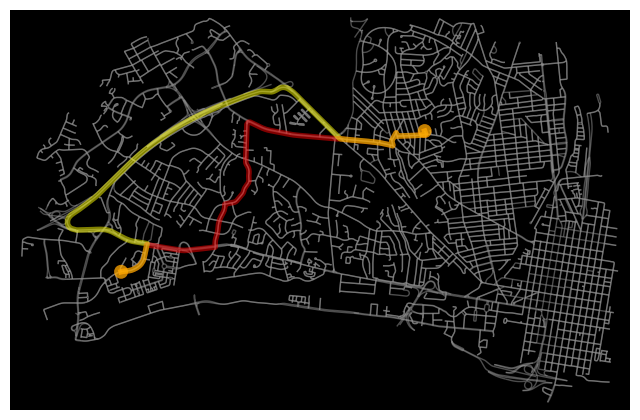

In [ ]:
# solve the route
route1 = nx.shortest_path(G_new, orig_node, dest_node, weight = 'length')
route2 = nx.shortest_path(G_new, orig_node, dest_node, weight = 'travel_time')
# plot the route
# use plot_graph_route function if you need to show only one route
fig, ax = ox.plot_graph_routes(G_new, [route1, route2], route_colors= ['red', 'yellow'],
                              route_linewidth=8, node_size=0, edge_alpha = 0.5, bgcolor='k')

You can perform mode-specific analysis (e.g., shortest route identified for walking, biking, driving), as well as specify other cost parameters as per you analitical needs.

# Service area analysis (Isochrones)

**Service areas (isochrone areas)** represent polygons/geographic regions within which people can access the service given a fixed origin, travel mode, and time threshold.  **Isochrone networks** identify the road network that falls within service area, and therefore traversible from the given origin, using the given travel time theshold and mode.

Such analysis are crucial for assessing who can reach essential services and activities, such as grocery stores, healthcare, and recreational facilities.


In [ ]:
# specifying the origin
orig = "4646 Seminary Rd, Alexandria, VA 22304" # Francis C. Hammond Middle School
# geocoding address to cordinate
orig_coord = ox.geocode(orig)
# geographic CRS to projected CRS
orig_x, orig_y = transformer.transform(orig_coord[1], orig_coord[0])
# identify nearest node
orig_node = ox.nearest_nodes(G_new, orig_x, orig_y)
orig_node

63748644

In [ ]:
# we can estimate isochrones for multiple time threshold
trip_times = [10, 7, 5]

In [ ]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="autumn", start=0)
iso_colors

['#ff0000', '#ff8000', '#ffff00']

We will use the **ego_graph** function to create isochrones. This function outputs a subnetwork representing all reachable roads from a given origin within the specified travel mode and time threshold.

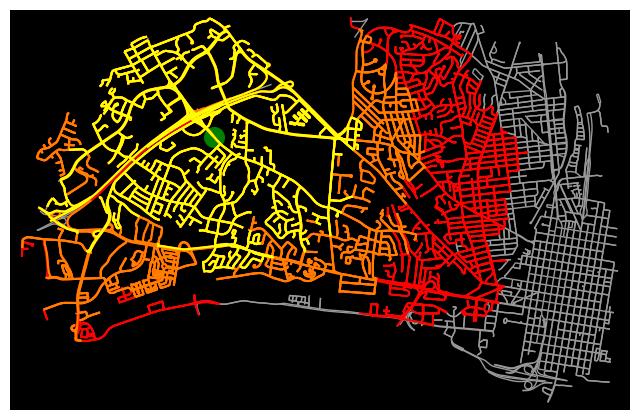

In [ ]:
# first plot the network in the background
fig, ax = ox.plot_graph(G_new, show=False, node_size=0, bgcolor='k')
# also plot the origin
orig_geom = gdf_nodes[gdf_nodes['osmid'] == orig_node]
orig_geom.plot(ax = ax, color= "green", markersize = 200)

# create subnetwork for each travel time and then add it to the plot
# note that I am plotting time values in descending order to make sure they are visible
for i in range(len(trip_times)):
    subgraph = nx.ego_graph(G_new, orig_node,
                            radius=trip_times[i] * 60, # trip times in minute, need to convert to second to match with travel time column
                            distance="travel_time")
    sub_nodes, sub_edges = ox.graph_to_gdfs(subgraph)
    sub_nodes = sub_nodes.reset_index()
    sub_edges = sub_edges.reset_index()

    sub_edges.plot(ax = ax, color= iso_colors[i])
